<a href="https://colab.research.google.com/github/Anusha-T8/LPG_SALES_FORECAST/blob/main/ARIMA_LPGDATA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [ ]:
df = pd.read_csv('/content/total-liquefied-petroleum-gas-sales-quarterly.csv',index_col=['quarter'])
df.head()

,level_1,values
quarter,,
1994-Q1,Total Liquefied Petroleum Gas Sales (Net Tonnes),29226.3
1994-Q2,Total Liquefied Petroleum Gas Sales (Net Tonnes),38153.9
1994-Q3,Total Liquefied Petroleum Gas Sales (Net Tonnes),39414.7
1994-Q4,Total Liquefied Petroleum Gas Sales (Net Tonnes),37600.3
1995-Q1,Total Liquefied Petroleum Gas Sales (Net Tonnes),34100.6


In [ ]:
del df['level_1']

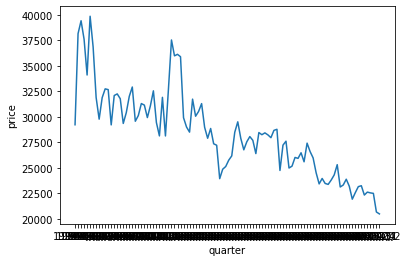

In [ ]:
plt.xlabel('quarter')
plt.ylabel('price')
plt.plot(df)

In [ ]:
df.rename(columns={'quarter':'Quarter','values':'Price'},inplace=True)

In [ ]:
df.head()

,Price
quarter,
1994-Q1,29226.3
1994-Q2,38153.9
1994-Q3,39414.7
1994-Q4,37600.3
1995-Q1,34100.6


In [ ]:
df.columns=["#Price"]

In [ ]:
#df.head()

In [ ]:
#result = seasonal_decompose(df['#Price'],  
                            #model ='multiplicative')

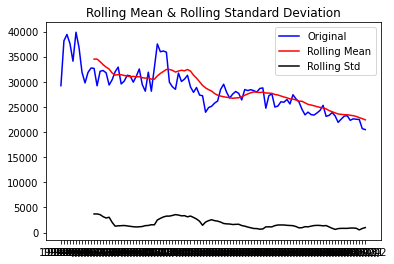

In [ ]:
rolling_mean = df.rolling(window = 12).mean()
rolling_std = df.rolling(window = 12).std()
plt.plot(df, color = 'blue', label = 'Original')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

In [ ]:
result = adfuller(df['#Price'])
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -0.288545073602864
p-value: 0.9271110971642786
Critical Values:
	1%: -3.506057133647011
	5%: -2.8946066061911946
	10%: -2.5844100201994697


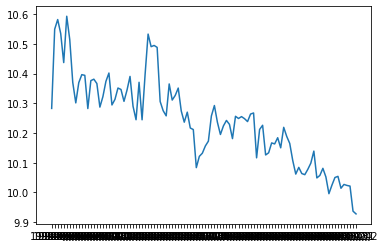

In [ ]:
df_log = np.log(df)
plt.plot(df_log)

In [ ]:
def get_stationarity(timeseries):
    
    # rolling statistics
    rolling_mean = timeseries.rolling(window=12).mean()
    rolling_std = timeseries.rolling(window=12).std()
    
    # rolling statistics plot
    original = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Dickey–Fuller test:
    result = adfuller(timeseries['#Price'])
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

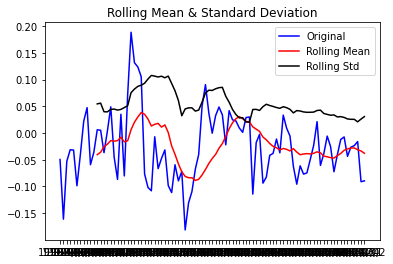

ADF Statistic: -2.6782840953943463
p-value: 0.07787204114324818
Critical Values:
	1%: -3.517113604831504
	5%: -2.8993754262546574
	10%: -2.5869547797501644


In [ ]:
rolling_mean = df_log.rolling(window=12).mean()
df_log_minus_mean = df_log - rolling_mean
df_log_minus_mean.dropna(inplace=True)
get_stationarity(df_log_minus_mean)

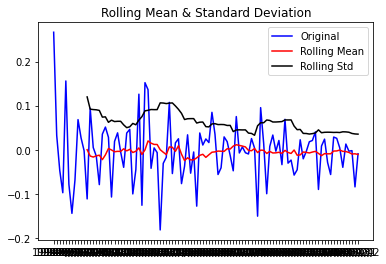

ADF Statistic: -2.213688734898497
p-value: 0.201314801398004
Critical Values:
	1%: -3.5078527246648834
	5%: -2.895382030636155
	10%: -2.584823877658872


In [ ]:
df_log_shift = df_log - df_log.shift()
df_log_shift.dropna(inplace=True)
get_stationarity(df_log_shift)

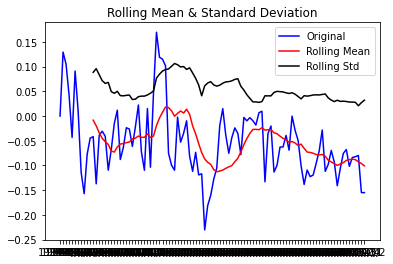

ADF Statistic: -2.247218267571286
p-value: 0.18955620076292984
Critical Values:
	1%: -3.506944401824286
	5%: -2.894989819214876
	10%: -2.584614550619835


In [ ]:
rolling_mean_exp_decay = df_log.ewm(halflife=12, min_periods=0, adjust=True).mean()
df_log_exp_decay = df_log - rolling_mean_exp_decay
df_log_exp_decay.dropna(inplace=True)
get_stationarity(df_log_exp_decay)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  % freq, ValueWarning)


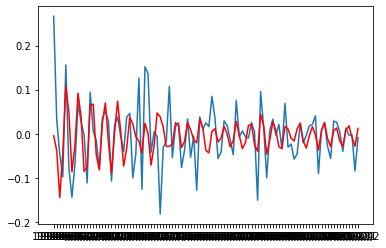

In [ ]:
import statsmodels.api as sm
decomposed = sm.tsa.seasonal_decompose(np.asarray(df), freq=3)
#decomposition = seasonal_decompose(df_log) 
model = ARIMA(df_log, order=(2,1,2))
results = model.fit(disp=-1)
plt.plot(df_log_shift)
plt.plot(results.fittedvalues, color='red')

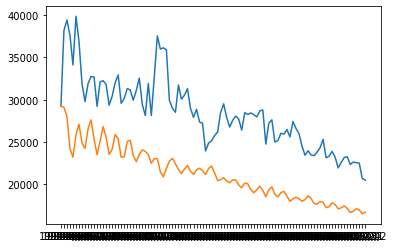

In [ ]:
predictions_ARIMA_diff = pd.Series(results.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(df_log['#Price'].iloc[0], index=df_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(df)
plt.plot(predictions_ARIMA)

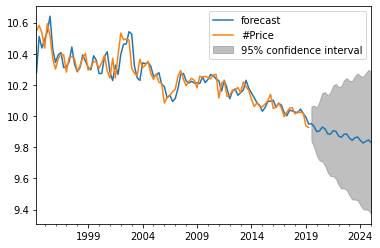

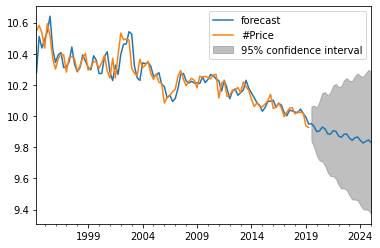

In [ ]:
results.plot_predict(1,124)